# Using the Cluster

In this example it is shown how to connect to an existing already running cluster.

First we need to get a gateway object.

In [18]:
from dask_gateway import Gateway

# Use values stored in your local configuration (recommended)
gateway = Gateway()

## List Clusters

The gateway object allows listing running clusters.

In [38]:
gateway.list_clusters()

[ClusterReport<name=dask.866de274e8c74c29aacd5f91878b7af3, status=RUNNING>]

## Connecting to a Cluster

Once your have a lits of clusters, you can connect to a running cluster using its name.

In [39]:
cluster = gateway.connect('dask.866de274e8c74c29aacd5f91878b7af3')

## Getting the Dask Client

The connected cluster allows retrieving a dask client you use in your computations.

In [43]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/dask.866de274e8c74c29aacd5f91878b7af3/status,


## Example

Use this example to observe the behaviour of your cluster in its dashboard.

In [44]:
import numpy as np
import xarray as xr
from dask.distributed import Client
from xcube.util.dask import compute_array_from_func


In [45]:
# The argument names passed to compute_my_chunk().
arg_names=['shape', 'dtype', 'block_shape', 'block_slices']

def compute_my_chunk(shape, dtype, block_shape, block_slices):
    """
    Called for every chunk.
    This example fills the chunk with unique numbers. 
    """
    bh, bw = block_shape
    (bsy, _), (bsx, _) = block_slices
    _, w = shape
    block = np.ndarray((bh, bw), dtype=dtype)
    for j in range(bh):
        for i in range(bw):
            block[j, i] = 0.1 * ((bsy + j) * w + bsx + i)
    return block

In [46]:
a = compute_array_from_func(compute_my_chunk, 
                            shape=(1024, 2048), 
                            chunks=(256, 512), 
                            dtype=np.float64, 
                            ctx_arg_names=arg_names)
a

dask.array<concatenate, shape=(1024, 2048), dtype=float64, chunksize=(256, 512), chunktype=numpy.ndarray>

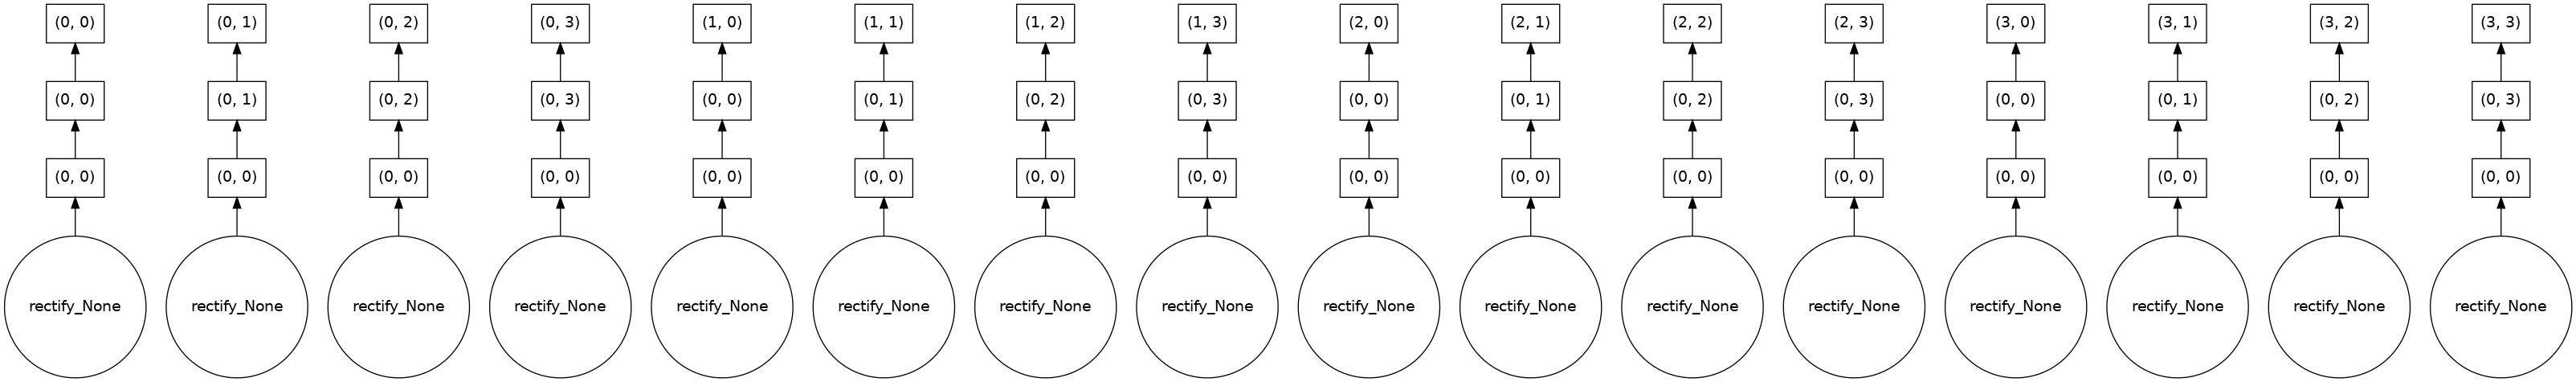

In [47]:
import graphviz
a.visualize()

In [48]:
np.array(a)

array([[0.000000e+00, 1.000000e-01, 2.000000e-01, ..., 2.045000e+02,
        2.046000e+02, 2.047000e+02],
       [2.048000e+02, 2.049000e+02, 2.050000e+02, ..., 4.093000e+02,
        4.094000e+02, 4.095000e+02],
       [4.096000e+02, 4.097000e+02, 4.098000e+02, ..., 6.141000e+02,
        6.142000e+02, 6.143000e+02],
       ...,
       [2.091008e+05, 2.091009e+05, 2.091010e+05, ..., 2.093053e+05,
        2.093054e+05, 2.093055e+05],
       [2.093056e+05, 2.093057e+05, 2.093058e+05, ..., 2.095101e+05,
        2.095102e+05, 2.095103e+05],
       [2.095104e+05, 2.095105e+05, 2.095106e+05, ..., 2.097149e+05,
        2.097150e+05, 2.097151e+05]])

In [49]:
da = xr.DataArray(a, dims=('y', 'x'))
da

<xarray.DataArray 'concatenate-84afec3b4d96b1a7334fc48c2ae94767' (y: 1024, x: 2048)>
dask.array<concatenate, shape=(1024, 2048), dtype=float64, chunksize=(256, 512), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x

## Shutdown the cluster

You can shutdown the server after your computations. Please note that you can use the `with` notation. It is not clear, though, how you would fo that in a notebook with various cells.

In [50]:
cluster.shutdown()